# Single Elders Home Monitoring : PCA filtering

In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import median_filter
import plotly
import plotly.express as px
import plotly.offline as py

# Enable offline mode
import plotly.io as pio
pio.renderers.keys()
pio.renderers.default = 'jupyterlab' 

In [2]:
no_occupants_df = pd.read_csv('./data/data_ref_until_2020-02-13.csv')
no_occupants_df

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
0,2020-01-25 00:01:49.251503+01:00,20.64,55.57,121.0,496.0,521.0,694.0,652.0,591.0,135.0
1,2020-01-25 00:02:09.350082+01:00,20.64,55.53,122.0,495.0,521.0,694.0,652.0,591.0,135.0
2,2020-01-25 00:02:29.319505+01:00,20.62,55.53,121.0,495.0,522.0,694.0,651.0,591.0,135.0
3,2020-01-25 00:02:49.399379+01:00,20.62,55.57,121.0,495.0,522.0,694.0,651.0,591.0,135.0
4,2020-01-25 00:03:09.158989+01:00,20.62,55.59,121.0,495.0,522.0,694.0,652.0,591.0,135.0
...,...,...,...,...,...,...,...,...,...,...
75506,2020-02-13 11:56:53.929978+01:00,20.62,57.75,62.0,518.0,524.0,698.0,642.0,591.0,157.0
75507,2020-02-13 11:57:14.204458+01:00,20.62,57.75,62.0,518.0,524.0,698.0,641.0,591.0,157.0
75508,2020-02-13 11:57:33.983249+01:00,20.62,57.75,62.0,518.0,524.0,698.0,641.0,591.0,157.0
75509,2020-02-13 11:57:54.058349+01:00,20.62,57.74,63.0,518.0,524.0,698.0,641.0,591.0,157.0


In [3]:
occupants_df = pd.read_csv('./data/database_gas.csv')
occupants_df

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
0,2019-11-06 11:37:13.038174+01:00,19.48,54.86,128.0,563.0,476.0,731.0,649.0,565.0,128.0
1,2019-11-06 11:37:32.744996+01:00,19.59,54.23,129.0,563.0,477.0,731.0,649.0,565.0,125.0
2,2019-11-06 11:37:53.018087+01:00,19.63,54.05,128.0,566.0,478.0,732.0,649.0,565.0,125.0
3,2019-11-06 11:38:13.093151+01:00,19.64,53.74,128.0,566.0,478.0,732.0,649.0,565.0,125.0
4,2019-11-06 11:38:33.032832+01:00,19.67,53.53,128.0,569.0,480.0,732.0,650.0,565.0,125.0
...,...,...,...,...,...,...,...,...,...,...
416148,2020-02-13 11:56:53.929978+01:00,20.62,57.75,62.0,518.0,524.0,698.0,642.0,591.0,157.0
416149,2020-02-13 11:57:14.204458+01:00,20.62,57.75,62.0,518.0,524.0,698.0,641.0,591.0,157.0
416150,2020-02-13 11:57:33.983249+01:00,20.62,57.75,62.0,518.0,524.0,698.0,641.0,591.0,157.0
416151,2020-02-13 11:57:54.058349+01:00,20.62,57.74,63.0,518.0,524.0,698.0,641.0,591.0,157.0


## Sliding window median filter

In [4]:
def sliding_window_median_filter(df, window_size):
    filtered_df = df.copy()

    for column in df.columns:
        filtered_df[column] = median_filter(df[column], size=window_size)

    return filtered_df

In [5]:
# filtering dataset of when no occupant is in the house

no_occupants_filtered_df = sliding_window_median_filter(no_occupants_df.drop(columns=['timestamp']), window_size=11)
occupants_filtered_df = sliding_window_median_filter(occupants_df.drop(columns=['timestamp']), window_size=11)


## PCA [fit] on no occupant data

In [6]:
# pca fit
# IMPORTANT: scikit PCA implementation subtracts the mean of the input data as part of the function
pca = PCA(n_components=4)
filtered_no_occupants = pca.fit_transform(no_occupants_filtered_df)

print('Variance explained by each dimension:\n', 
      *[f'PCA component {i+1}: {round(pca.explained_variance_ratio_[i]*100,2)} % \n' for i in range (len(pca.explained_variance_ratio_))])

Variance explained by each dimension:
 PCA component 1: 69.26 % 
 PCA component 2: 17.1 % 
 PCA component 3: 5.97 % 
 PCA component 4: 4.75 % 



## PCA inference

### No occupant data - before enviromental correction

In [7]:
no_occupants_df['timestamp'][0]

'2020-01-25 00:01:49.251503+01:00'

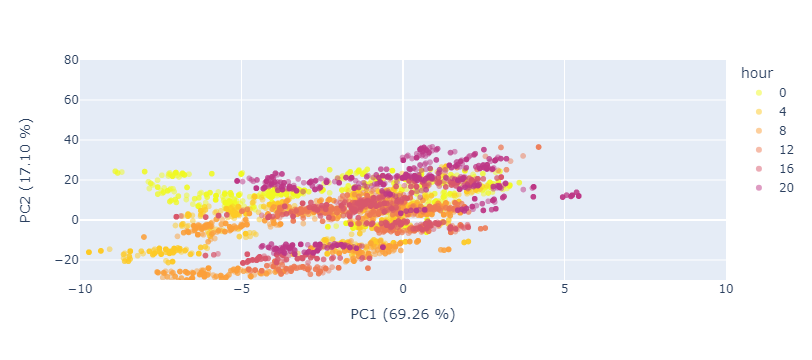

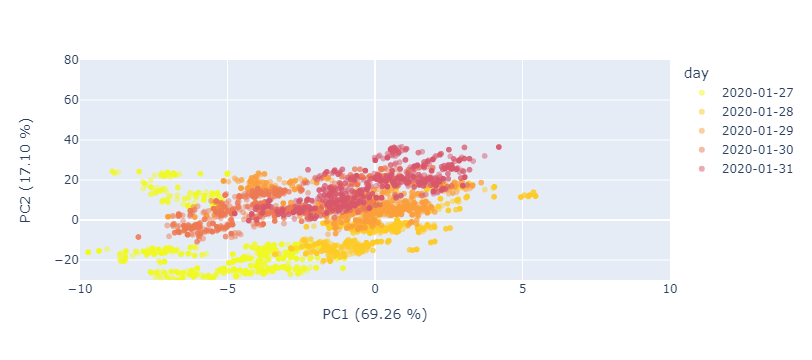

In [8]:
# Query the DataFrame for the date range
start_date = np.datetime64('2020-01-27')
end_date = np.datetime64('2020-02-01')
no_occupants_df['timestamp'] = pd.to_datetime(no_occupants_df['timestamp']).dt.tz_localize(None)
visual_days = ((no_occupants_df['timestamp'] >= start_date) & (no_occupants_df['timestamp'] <= end_date) & 
               ((no_occupants_df['timestamp'].dt.hour == 0) | (no_occupants_df['timestamp'].dt.hour == 4) | 
                (no_occupants_df['timestamp'].dt.hour == 8) | (no_occupants_df['timestamp'].dt.hour == 12) | 
                (no_occupants_df['timestamp'].dt.hour == 16) | (no_occupants_df['timestamp'].dt.hour == 20)))

visual_data = filtered_no_occupants[visual_days]
visual_data_days_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'day':pd.to_datetime(no_occupants_df['timestamp'][visual_days]).dt.date})
visual_data_hours_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'hour':pd.to_datetime(no_occupants_df['timestamp'][visual_days]).dt.hour.astype('str')})
var_new_proj = pca.explained_variance_ratio_


## Plot no occupant data before environmental correction by hour
fig = px.scatter(visual_data_hours_df, x='PC1', y='PC2', color='hour', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100),
    xaxis_range=[-10, 10],
    yaxis_range=[-30, 80]  
)
fig.show()


## Plot no occupant data before environmental correction by day
fig = px.scatter(visual_data_days_df, x='PC1', y='PC2', color='day', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100),
    xaxis_range=[-10, 10],
    yaxis_range=[-30, 80]  
)
fig.show()

PCA space representation of the data set without human activity before environmental correction. Samples colored by time of the day (top) and colored by day (bottom). Due to environmental factors, the samples are ordered by time of the day or by the day of acquisition.

### No occupant data - before enviromental correction

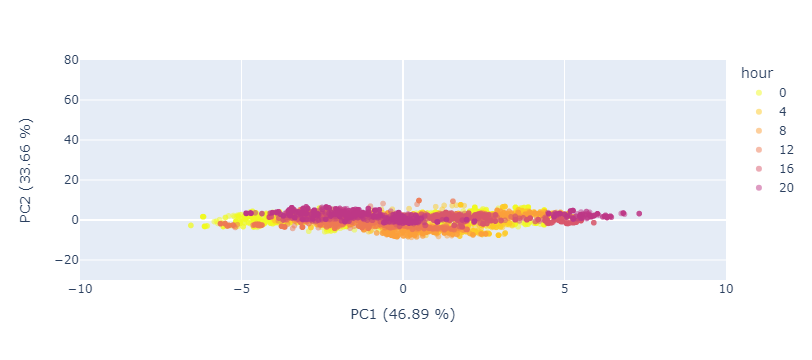

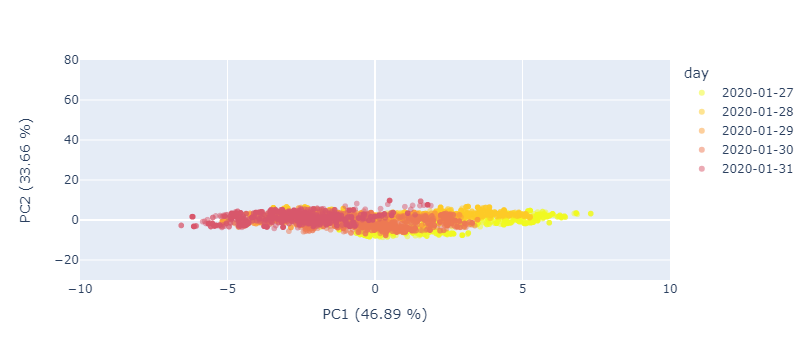

In [9]:

transformed_data_without_first_component = visual_data.copy()

# removing first component of PCA by setting it to zero
transformed_data_without_first_component[:,0] = 0

# reprojecting data in original space without first component
inv_transf = pca.inverse_transform(transformed_data_without_first_component)

# building new PCA on data without first component
pca_after_corr = PCA(n_components=2)
visual_data = pca_after_corr.fit_transform(inv_transf)
var_new_proj = pca_after_corr.explained_variance_ratio_

visual_data_day_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'day':pd.to_datetime(no_occupants_df['timestamp'][visual_days]).dt.date})
visual_data_hours_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'hour':pd.to_datetime(no_occupants_df['timestamp'][visual_days]).dt.hour.astype('str')})

## Plot no occupant data after environmental correction by hour
fig = px.scatter(visual_data_hours_df, x='PC1', y='PC2', color='hour', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100),
    xaxis_range=[-10, 10],
    yaxis_range=[-30, 80]  
)
fig.show()

## Plot no occupant data after environmental correction by day
fig = px.scatter(visual_data_day_df, x='PC1', y='PC2', color='day', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100),
    xaxis_range=[-10, 10],
    yaxis_range=[-30, 80]   
)
fig.show()

PCA space representation of the data set without human activity after environmental correction. Samples colored by time of the day (top) and colored by day (bottom). The samples overlap each other, with a reduced structure on the environmental factors.